# La Réunion: download and plot

This minimal notebook downloads a GMRT GeoTIFF for La Réunion and plots it on a map.

- Bounds (lon/lat): [55.0, -21.5, 56.0, -20.5]
- Format: geotiff (medium resolution)
- Output folder: ./data

## Quick import and help

In [76]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from matplotlib.colors import LightSource
from pygmrt.tiles import download_tiles, get_path
from scipy.ndimage import gaussian_filter

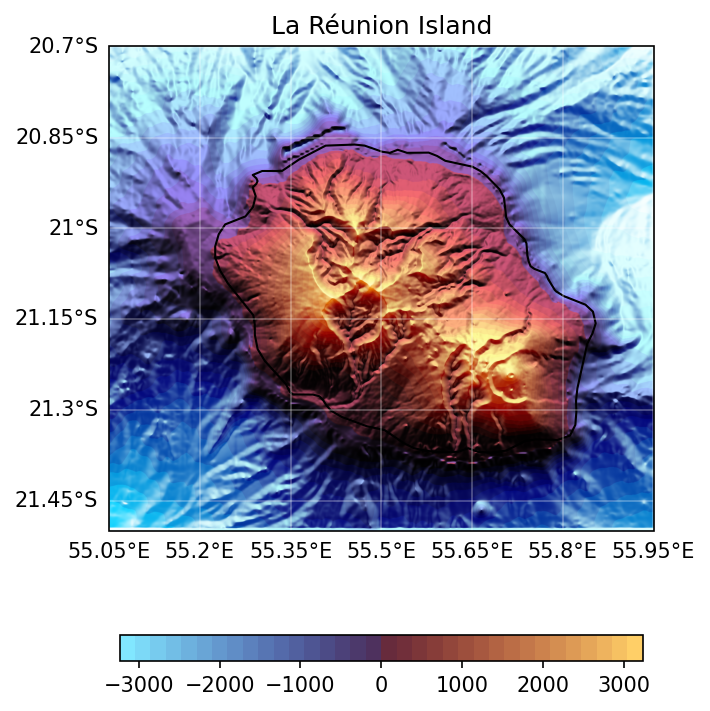

In [75]:
# La Réunion bbox [west, south, east, north]
bbox = [55.05, -21.5, 55.95, -20.7]

# Force re-download to avoid stale/corrupt cache if needed
tiles = download_tiles(bbox=bbox, resolution="high", overwrite=False)
# Use helper to get a GeoTIFF path (raises if none found)
# filepath = get_path(result)

# Colormap is managua_r with n discrete colors, with removing the 3 center colors
# to have a better contrast between land and ocean
n = 37
cmap = plt.get_cmap("managua_r", n)
cmap = cmap(np.arange(cmap.N))
cmap = np.delete(cmap, [n // 2 - 1, n // 2, n // 2 + 1], axis=0)
cmap = plt.matplotlib.colors.ListedColormap(cmap)

# Plot
# with rasterio.open(filepath) as src:
topo = tiles.read(1)
topo[np.isnan(topo)] = 0
topo = gaussian_filter(topo, 3)
# print(src.crs)

vabsmax = np.nanmax(abs(topo))
bbox = tiles.bounds
extent = (bbox.left, bbox.right, bbox.bottom, bbox.top)
# print(extent)
# left, top = xy(src.transform, 0, 0)  # top-left pixel center
# right, bottom = xy(
#     src.transform, src.height - 1, src.width - 1
# )  # bottom-right pixel center
# extent = [left, right, bottom, top]
# b = src.bounds
# extent = (b.left, b.right, b.bottom, b.top)

fig, ax = plt.subplots(
    subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 6), dpi=150
)

sun = LightSource(azdeg=0, altdeg=20)
shade = sun.shade(topo, cmap=cmap, vmin=-vabsmax, vmax=vabsmax)
ax.imshow(shade, extent=extent, origin="upper", transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent(extent)
gridlines = ax.gridlines(draw_labels=True, color="white", alpha=0.3)
gridlines.top_labels = False
gridlines.right_labels = False
ax.set_title("La Réunion Island")

colorbar = plt.cm.ScalarMappable(cmap=cmap)
colorbar.set_array(topo)
colorbar.set_clim(-vabsmax, vabsmax)
plt.colorbar(colorbar, ax=ax, orientation="horizontal", shrink=0.5)

plt.show()

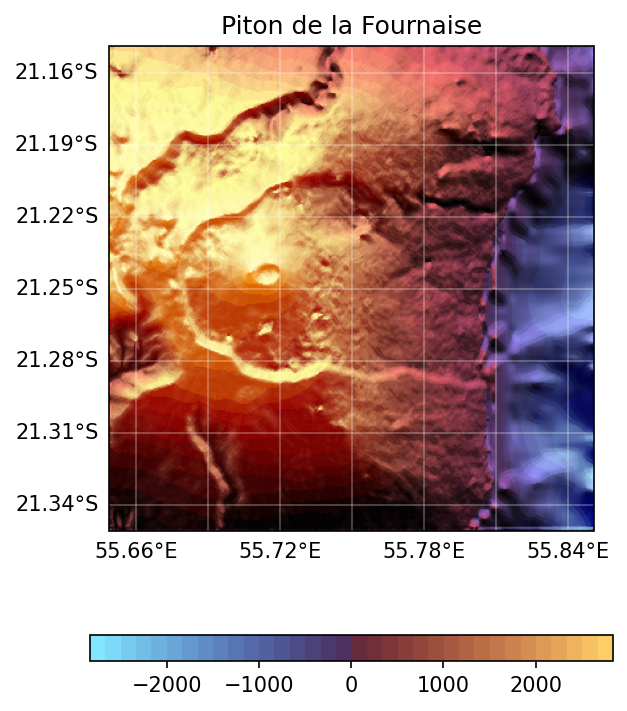

In [35]:
# Piton de la Fournaise
bbox = [55.65, -21.35, 55.85, -21.15]

# Force re-download to avoid stale/corrupt cache if needed
result = download_tiles(bbox=bbox, resolution="low", overwrite=False)

# Use helper to get a GeoTIFF path (raises if none found)
filepath = get_path(result)

# Colormap is managua_r with n discrete colors, with removing the 3 center colors
# to have a better contrast between land and ocean
n = 37
cmap = plt.get_cmap("managua_r", n)
cmap = cmap(np.arange(cmap.N))
cmap = np.delete(cmap, [n // 2 - 1, n // 2, n // 2 + 1], axis=0)
cmap = plt.matplotlib.colors.ListedColormap(cmap)

# Plot
with rasterio.open(filepath) as src:
    topo = src.read(1)
    topo[np.isnan(topo)] = 0
    topo = median_filter(topo, size=5)

    vabsmax = np.nanmax(abs(topo)) * 1.1
    bbox = src.bounds
    extent = (bbox.left, bbox.right, bbox.bottom, bbox.top)

    fig, ax = plt.subplots(
        subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 6), dpi=150
    )
    sun = LightSource(azdeg=0, altdeg=20)
    shade = sun.shade(topo, cmap=cmap, vmin=-vabsmax, vmax=vabsmax)

    ax.imshow(
        shade, extent=extent, origin="upper", transform=ccrs.PlateCarree()
    )
    gridlines = ax.gridlines(draw_labels=True, color="white", alpha=0.3)
    gridlines.top_labels = False
    gridlines.right_labels = False
    ax.set_title("Piton de la Fournaise")

    colorbar = plt.cm.ScalarMappable(cmap=cmap)
    colorbar.set_array(topo)
    colorbar.set_clim(-vabsmax, vabsmax)
    plt.colorbar(colorbar, ax=ax, orientation="horizontal", shrink=0.5)

    plt.show()

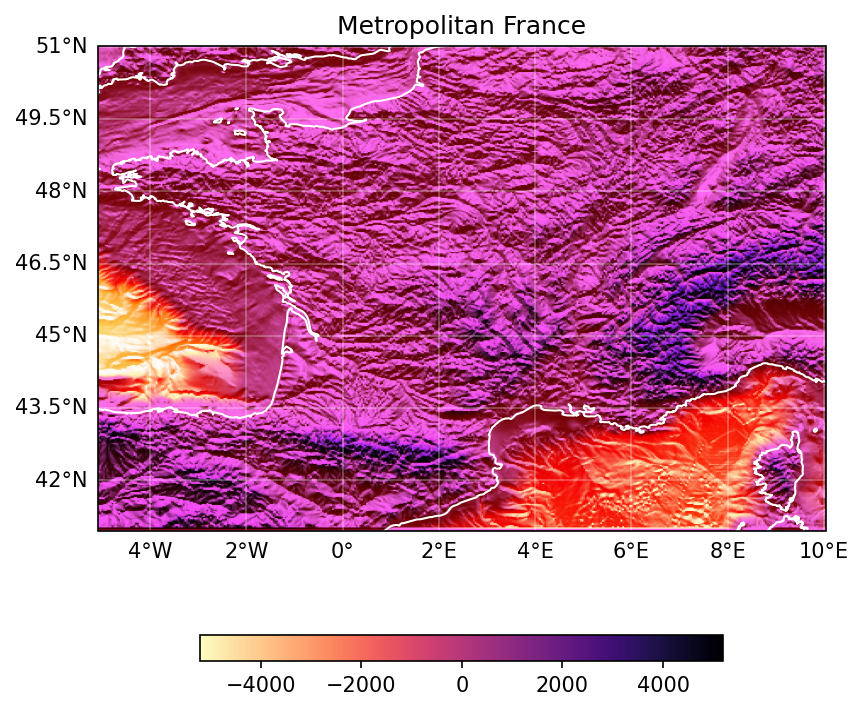

In [63]:
# France
bbox = [-5, 41, 10, 51]

# Force re-download to avoid stale/corrupt cache if needed
result = download_tiles(bbox=bbox, resolution="low", overwrite=False)

# Use helper to get a GeoTIFF path (raises if none found)
filepath = get_path(result)

# Colormap is managua_r with n discrete colors, with removing the 3 center colors
# to have a better contrast between land and ocean
# n = 27
# cmap = plt.get_cmap("RdGy_r", n)
cmap = plt.cm.magma_r
# cmap = cmap(np.arange(cmap.N))
# cmap = np.delete(cmap, [n // 2 - 1, n // 2, n // 2 + 1], axis=0)
# cmap = plt.matplotlib.colors.ListedColormap(cmap)

# Plot
with rasterio.open(filepath) as src:
    topo = src.read(1)
    topo[np.isnan(topo)] = 0
    # topo = gaussian_filter(topo, 1)

    vabsmax = np.nanmax(abs(topo)) * 1.1
    bbox = src.bounds
    extent = (bbox.left, bbox.right, bbox.bottom, bbox.top)

    fig, ax = plt.subplots(
        subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 6), dpi=150
    )
    sun = LightSource(azdeg=0, altdeg=20)
    shade = sun.shade(topo, cmap=cmap, vmin=-vabsmax, vmax=vabsmax)

    ax.imshow(
        shade, extent=extent, origin="upper", transform=ccrs.PlateCarree()
    )
    ax.coastlines(color="white")
    gridlines = ax.gridlines(draw_labels=True, color="white", alpha=0.3)
    gridlines.top_labels = False
    gridlines.right_labels = False
    ax.set_title("Metropolitan France")

    colorbar = plt.cm.ScalarMappable(cmap=cmap)
    colorbar.set_array(topo)
    colorbar.set_clim(-vabsmax, vabsmax)
    plt.colorbar(colorbar, ax=ax, orientation="horizontal", shrink=0.5)

    plt.show()